In [ ]:
# pip install --upgrade tensorflow

In [ ]:
# !pip install tensorflow==2.17 numpy==1.26.2

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, classification_report

base_dir = r'..\data'
train_dir = os.path.join(base_dir, 'train_aug')
# train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 15648 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
# Load ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [28]:
# # Calculate class weights (optional)
# from sklearn.utils import class_weight

# class_weights = class_weight.compute_class_weight(
#     'balanced',
#     np.unique(train_generator.classes),
#     train_generator.classes
# )

In [29]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')

model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    callbacks=[early_stopping, model_checkpoint],
    #class_weight=dict(enumerate(class_weights))  # if using class weights
)


Epoch 1/20
489/489 [==============================] - 143s 280ms/step - loss: 0.1967 - accuracy: 0.9259 - val_loss: 1133.4823 - val_accuracy: 0.5000
Epoch 2/20
489/489 [==============================] - 103s 209ms/step - loss: 0.0807 - accuracy: 0.9685 - val_loss: 2.7385 - val_accuracy: 0.5000
Epoch 3/20
489/489 [==============================] - 103s 211ms/step - loss: 0.0539 - accuracy: 0.9808 - val_loss: 0.1647 - val_accuracy: 0.9375
Epoch 4/20
489/489 [==============================] - 123s 252ms/step - loss: 0.0445 - accuracy: 0.9843 - val_loss: 1.1446 - val_accuracy: 0.7500
Epoch 5/20
489/489 [==============================] - 108s 220ms/step - loss: 0.0434 - accuracy: 0.9844 - val_loss: 1.4839 - val_accuracy: 0.6250
Epoch 6/20
489/489 [==============================] - 103s 210ms/step - loss: 0.0286 - accuracy: 0.9905 - val_loss: 15.8576 - val_accuracy: 0.5000
Epoch 7/20
489/489 [==============================] - 102s 209ms/step - loss: 0.0259 - accuracy: 0.9905 - val_loss: 0.41

20/20 [==============================] - 6s 256ms/step - loss: 4.9059 - accuracy: 0.6683
Test accuracy: 0.6682692170143127
20/20 [==============================] - 7s 293ms/step
Confusion Matrix:
[[ 28 206]
 [  1 389]]
Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.97      0.12      0.21       234
   PNEUMONIA       0.65      1.00      0.79       390

    accuracy                           0.67       624
   macro avg       0.81      0.56      0.50       624
weighted avg       0.77      0.67      0.57       624



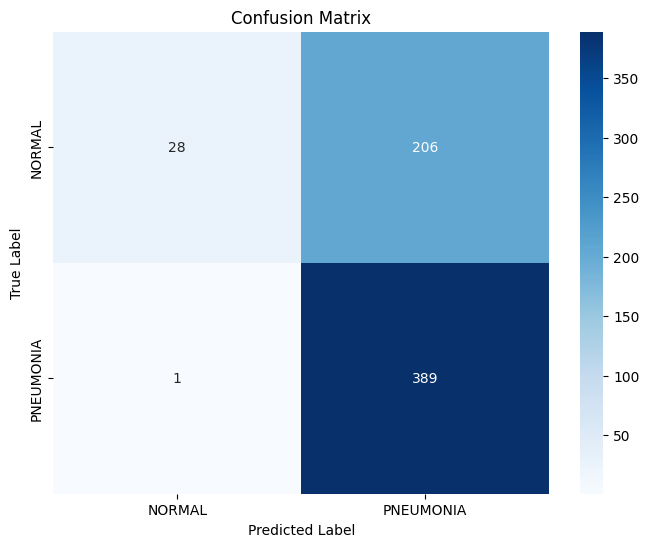

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

# Get predictions
test_generator.reset()
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype(int).flatten()

# True labels
true_classes = test_generator.classes

conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

class_report = classification_report(true_classes, predicted_classes, target_names=['NORMAL', 'PNEUMONIA'])
print("Classification Report:")
print(class_report)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()